In [58]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in 10x files

In [59]:
import scanpy as sc
import pandas as pd
import numpy as np
import gzip
import tempfile
from pathlib import Path
from typing import Optional, Union
import anndata as ad
import celltypist
from scipy import sparse

# ──────────────────────────────────────────────────────────────────────────
# I/O helpers
# ──────────────────────────────────────────────────────────────────────────
def load_data(data_dir: Path) -> sc.AnnData:
    """
    Read all 10x‑MTX triples in `data_dir`, add metadata, concatenate,
    and return one AnnData with batch key 'sample'.

    Expects filenames like:
      <sample>_matrix.mtx.gz, where <sample> encodes
      GSM_Donor_Tissue[_Extra...], e.g. GSM123_MS1_CSF_GRCh38

    Parses GSM, donor, and tissue from the first 3 underscore-separated fields.
    """
    sample_ids = sorted(
        p.name.replace("_matrix.mtx.gz", "")
        for p in data_dir.glob("*_matrix.mtx.gz")
    )

    def read_one(sid: str) -> sc.AnnData:
        with tempfile.TemporaryDirectory() as tdir:
            tdir = Path(tdir)
            for suffix in ["barcodes.tsv", "genes.tsv", "matrix.mtx"]:
                with gzip.open(data_dir / f"{sid}_{suffix}.gz", "rt", encoding="utf-8") as r, \
                     open(tdir / suffix, "w", encoding="utf-8") as w:
                    w.write(r.read())

            adata = sc.read_10x_mtx(tdir, var_names="gene_symbols", cache=False)

        adata.var_names_make_unique()

        # parse metadata from sample ID
        parts = sid.split("_")
        if len(parts) < 3:
            raise ValueError(f"Sample ID {sid!r} doesn't match expected format GSM_Donor_Tissue[_...]")
        gsm, donor, tissue = parts[0], parts[1], parts[2]

        adata.obs["sample_id"] = sid
        adata.obs["donor_id"] = donor
        adata.obs["tissue"] = tissue
        adata.obs["disease"] = "MS" if "MS" in donor else "Control"
        return adata

    adatas = [read_one(sid) for sid in sample_ids]
    return adatas[0].concatenate(
        *adatas[1:],
        batch_key="sample",
        batch_categories=sample_ids,
        index_unique="-"
    )
    
# ──────────────────────────────────────────────────────────────────────────
# QC / normalisation
# ──────────────────────────────────────────────────────────────────────────
def prepare_adata(
        adata: sc.AnnData,
        min_genes: int = 200,
        min_cells: int = 3,
        mito_prefix: str = 'MT-',
        pct_mt_cutoff: Optional[float] = 15,
        copy: bool = False
) -> sc.AnnData:
    """
    Basic Scanpy pipeline that **keeps** mitochondrial genes.

    Adds:
      • adata.layers['counts']  raw sparse counts
      • adata.raw               log‑normed matrix (all genes)
      • .var['highly_variable'] boolean flag (Seurat v3 flavour)
    """
    ad = adata.copy() if copy else adata

    # cell / gene filters
    sc.pp.filter_cells(ad, min_genes=min_genes)
    sc.pp.filter_genes(ad,  min_cells=min_cells)

    # QC metrics
    ad.var['mt'] = ad.var_names.str.startswith(mito_prefix)
    sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True)

    if pct_mt_cutoff is not None:
        ad = ad[ad.obs.pct_counts_mt < pct_mt_cutoff].copy()

    # store counts layer
    ad.layers['counts'] = ad.X.copy()

    # normalise & log1p
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

    # mark HVGs (do NOT subset)
    sc.pp.highly_variable_genes(ad, n_top_genes=3000,
                                subset=False, layer=None)

    sc.pp.scale(ad, max_value=10)
    ad.raw = ad                          # full log‑normed matrix
    return ad

# ──────────────────────────────────────────────────────────────────────────
# CellTypist preparation
# ──────────────────────────────────────────────────────────────────────────
# ──────────────────────────────────────────────────────────────────────────
# Sparse safety helper
# ──────────────────────────────────────────────────────────────────────────
def _to_csr(mat):
    """Ensure sparse matrix is CSR; otherwise return unchanged."""
    return mat.tocsr(copy=False) if sparse.issparse(mat) and mat.format != "csr" else mat

# ──────────────────────────────────────────────────────────────────────────
# CellTypist preparation
# ──────────────────────────────────────────────────────────────────────────
def _clean_nan_inf(X):
    """Remove NaNs and infs from sparse or dense matrices."""
    if sparse.issparse(X):
        X = X.tocsr(copy=False)
        bad = ~np.isfinite(X.data)
        if np.any(bad):
            X.data[bad] = 0.0
    else:
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    return X


def prepare_for_celltypist(
        adata: ad.AnnData,
        target_sum: int = 10_000,
        layer_out: str = "log_norm",
        clip: bool = True,
        inplace: bool = True,
) -> ad.AnnData:
    """
    Create a log1p‑CPM layer and store it in both `adata.layers[layer_out]`
    and `.raw`, converting everything to CSR and removing NaNs/infs.
    """
    if "counts" not in adata.layers:
        if adata.raw is not None:
            adata.layers["counts"] = adata.raw.X.copy()
        else:
            adata.layers["counts"] = adata.X.copy()

    ad = adata if inplace else adata.copy()
    X = ad.layers["counts"]
    if sparse.issparse(X):
        X = X.tocsr(copy=False)

    # normalize to CPM
    libsize = np.asarray(X.sum(axis=1)).flatten()
    libsize[libsize == 0] = 1.0
    norm_factor = target_sum / libsize

    if sparse.issparse(X):
        X_norm = X.multiply(norm_factor[:, None])
        X_norm.data = np.log1p(X_norm.data, dtype=np.float32)
    else:
        X_norm = np.log1p(X * norm_factor[:, None], dtype=np.float32)

    # clip after log1p
    if clip:
        hi = np.log1p(target_sum)
        if sparse.issparse(X_norm):
            X_norm.data = np.clip(X_norm.data, 0, hi)
        else:
            np.clip(X_norm, 0, hi, out=X_norm)

    # remove NaN and inf
    X_norm = _clean_nan_inf(X_norm)

    # force CSR for X_norm now
    X_norm = _to_csr(X_norm)

    # store in layers and convert layers to CSR
    ad.layers[layer_out] = X_norm
    ad.X = _to_csr(ad.X)
    for k in list(ad.layers.keys()):
        ad.layers[k] = _to_csr(ad.layers[k])

    # now set .raw after all CSR conversions
    ad.X = X_norm.copy()
    raw_copy = ad.copy()
    raw_copy.X = X_norm
    for k in list(raw_copy.layers.keys()):
        raw_copy.layers[k] = _to_csr(raw_copy.layers[k])
    ad.raw = raw_copy

    return ad

# ──────────────────────────────────────────────────────────────────────────
# CellTypist annotation wrapper
# ──────────────────────────────────────────────────────────────────────────
def run_celltypist(
    adata: ad.AnnData,
    model_path: Union[str, Path],
    majority_voting: bool = True,
    label_key: str = "cell_type",
) -> ad.AnnData:
    """
    • Prepares `.raw` and `.layers` for CellTypist
    • Intersects model genes
    • Avoids slicing errors by materializing .copy()
    """
    prepare_for_celltypist(adata, inplace=True)

    model = celltypist.models.Model.load(model_path)
    model_genes = pd.Index(model.features, name="gene")
    common = model_genes.intersection(adata.raw.var_names)

    # 👇 avoids any slicing issues (coo_matrix etc)
    ad_view = adata[:, common].copy()

    pred = celltypist.annotate(
        ad_view,
        model=model,
        majority_voting=majority_voting,
    )
    key = "majority_voting" if majority_voting else "raw"
    adata.obs[label_key] = pred.predicted_labels[key]

    return adata


/Users/aru/Development/powerhouse-bio-takehome/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [60]:
adata_fn = '../data/GSE138266.h5ad'
if not Path(adata_fn).exists():
    adata = load_data(Path("../data/GSE138266"))
    adata.write(adata_fn)
else:
    adata = sc.read_h5ad(adata_fn)
print(adata)


AnnData object with n_obs × n_vars = 814177 × 33694
    obs: 'sample_id', 'donor_id', 'tissue', 'disease', 'sample'
    var: 'gene_ids'


In [61]:
adata = prepare_adata(adata, pct_mt_cutoff=15)
adata

AnnData object with n_obs × n_vars = 76162 × 23543
    obs: 'sample_id', 'donor_id', 'tissue', 'disease', 'sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts'

# CellTypist

In [5]:
adata = run_celltypist(adata, "../data/Immune_All_Low.pkl")

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 76162 cells and 5459 genes
🔗 Matching reference genes in the model
🧬 5459 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [6]:
# # temporarily set .X to log_norm
# adata.X = adata.layers["log_norm"]

# run PCA using only highly variable genes
sc.tl.pca(adata, use_highly_variable=True)

# build neighbor graph
sc.pp.neighbors(adata, use_rep="X_pca")

# run UMAP
sc.tl.umap(adata)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Optional, Union
from pathlib import Path
import anndata as ad
from matplotlib.colors import to_hex
from matplotlib import cm
from scipy import sparse
from adjustText import adjust_text

def plot_pca(
    adata: ad.AnnData,
    color_by: Union[str, np.ndarray],
    shape_by: Optional[str] = None,
    ax: Optional[plt.Axes] = None,
    figsize: tuple = (6, 5),
    s: float = 1.0,  # POINT SIZE
    alpha: float = 0.8,
    title: Optional[str] = None,
    legend_out: bool = True,
    palette: Optional[Union[str, list, dict]] = None,
    cmap: str = "viridis",
    return_fig: bool = False,
    save: Optional[Union[str, Path]] = None,
):
    """
    Plot PCA with flexible coloring.

    Parameters:
    - color_by: obs column or gene name (str) or array
    - shape_by: obs column (str)
    - s: point size (float)
    - save: file path to write figure (optional)
    """
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True

    x = adata.obsm["X_pca"][:, 0]
    y = adata.obsm["X_pca"][:, 1]
    color_vals = _get_plot_values(adata, color_by)

    scatter_kws = dict(
        x=x,
        y=y,
        s=s,
        alpha=alpha,
        linewidth=0,
        ax=ax,
    )

    if pd.api.types.is_numeric_dtype(color_vals):
        sns.scatterplot(**scatter_kws, hue=color_vals, palette=cmap, legend=False)
        if created_fig:
            fig.colorbar(ax.collections[0], ax=ax, label=color_by)
    else:
        sns.scatterplot(**scatter_kws, hue=color_vals, style=adata.obs[shape_by] if shape_by else None, palette=palette, legend='full')
        if legend_out:
            ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=5)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(title or str(color_by))

    if save:
        fig.savefig(save, dpi=300, bbox_inches="tight")

    return (fig, ax) if return_fig else ax


# ──────────────────────────────────────────────────────────────────────────
# util: safe value accessor
# ──────────────────────────────────────────────────────────────────────────
# ───────────────────────────────────────────────────────────────
# util: handle obs or gene inputs
# ───────────────────────────────────────────────────────────────
def _get_plot_values(adata, color_by: Union[str, np.ndarray]) -> pd.Series:
    if isinstance(color_by, str):
        if color_by in adata.obs:
            return adata.obs[color_by]
        elif color_by in adata.var_names:
            X = (
                adata.raw[:, color_by].X
                if adata.raw is not None and color_by in adata.raw.var_names
                else adata[:, color_by].X
            )
            return pd.Series(X.toarray().flatten() if sparse.issparse(X) else X.flatten(), index=adata.obs_names)
        else:
            raise ValueError(f"{color_by!r} not found in `.obs` or `.var_names`.")
    elif isinstance(color_by, (pd.Series, np.ndarray)):
        return pd.Series(color_by, index=adata.obs_names)
    else:
        raise TypeError(f"color_by must be a string or array-like, not {type(color_by)}")

# ───────────────────────────────────────────────────────────────
# util: get distinct colors
# ───────────────────────────────────────────────────────────────
def get_distinct_palette(n: int) -> list:
    return sns.color_palette("tab20", n) if n <= 20 else sns.color_palette("husl", n)


def add_cluster_labels(
    adata: ad.AnnData,
    ax: plt.Axes,
    label_by: str,
    use_rep: str = "X_umap",
    arrowprops: Optional[dict] = None,
    textprops: Optional[dict] = None,
    labelsize: int = 10,
    with_arrows: bool = True,
):
    """
    Place labels at cluster centroids using adjustText to avoid overlap.
    """
    coords = adata.obsm[use_rep]
    df = pd.DataFrame(coords, columns=["x", "y"], index=adata.obs_names)
    df[label_by] = adata.obs[label_by]

    texts = []
    for label, group in df.groupby(label_by):
        x_mean, y_mean = group[["x", "y"]].mean()
        txt = ax.text(
            x_mean, y_mean, label,
            fontsize=labelsize,
            fontweight="bold",
            color="black",
            ha="center",
            **(textprops or {})
        )
        texts.append(txt)

    adjust_text(
        texts,
        ax=ax,
        expand_text=(1.2, 1.2),
        arrowprops=arrowprops if with_arrows else None,
        only_move={'points':'', 'text':'xy'}
    )

# ───────────────────────────────────────────────────────────────
# main UMAP plotting function
# ───────────────────────────────────────────────────────────────
def plot_umap(
    adata: ad.AnnData,
    color_by: Union[str, np.ndarray],
    shape_by: Optional[str] = None,
    ax: Optional[plt.Axes] = None,
    figsize: tuple = (6, 5),
    s: float = 1.0,
    alpha: float = 0.8,
    title: Optional[str] = None,
    legend_out: bool = True,
    palette: Optional[Union[str, list, dict]] = None,
    cmap: str = "viridis",
    return_fig: bool = False,
    save: Optional[Union[str, Path]] = None,
    label_clusters: bool = False,
    label_field: Optional[str] = None,
    labelsize=10,
    arrowprops: Optional[dict] = None,
    textprops: Optional[dict] = None,
) -> Union[plt.Axes, tuple[plt.Figure, plt.Axes]]:
    """
    Plot UMAP with obs/gene coloring, optional cluster labeling, and styling control.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    X = adata.obsm["X_umap"]
    color_vals = _get_plot_values(adata, color_by)

    scatter_kws = dict(
        x=X[:, 0],
        y=X[:, 1],
        s=s,
        alpha=alpha,
        linewidth=0,
        ax=ax,
    )

    if pd.api.types.is_numeric_dtype(color_vals):
        sns.scatterplot(**scatter_kws, hue=color_vals, palette=cmap, legend=False)
        fig.colorbar(ax.collections[0], ax=ax, label=color_by)
    else:
        if palette is None:
            n_cats = adata.obs[color_by].nunique()
            palette = get_distinct_palette(n_cats)

        sns.scatterplot(**scatter_kws, hue=color_vals,
                        style=adata.obs[shape_by] if shape_by else None,
                        palette=palette,
                        legend='full')
        if legend_out:
            ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=5)

    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_title(title or str(color_by))

    if label_clusters:
        add_cluster_labels(
            adata,
            ax,
            label_by=label_field or color_by,
            arrowprops=arrowprops,
            textprops=textprops,
            labelsize=labelsize
        )

    if save:
        fig.savefig(save, dpi=300, bbox_inches="tight")

    return (fig, ax) if return_fig else ax


<Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

<Axes: title={'center': 'disease'}, xlabel='UMAP1', ylabel='UMAP2'>

<Axes: title={'center': 'tissue'}, xlabel='UMAP1', ylabel='UMAP2'>

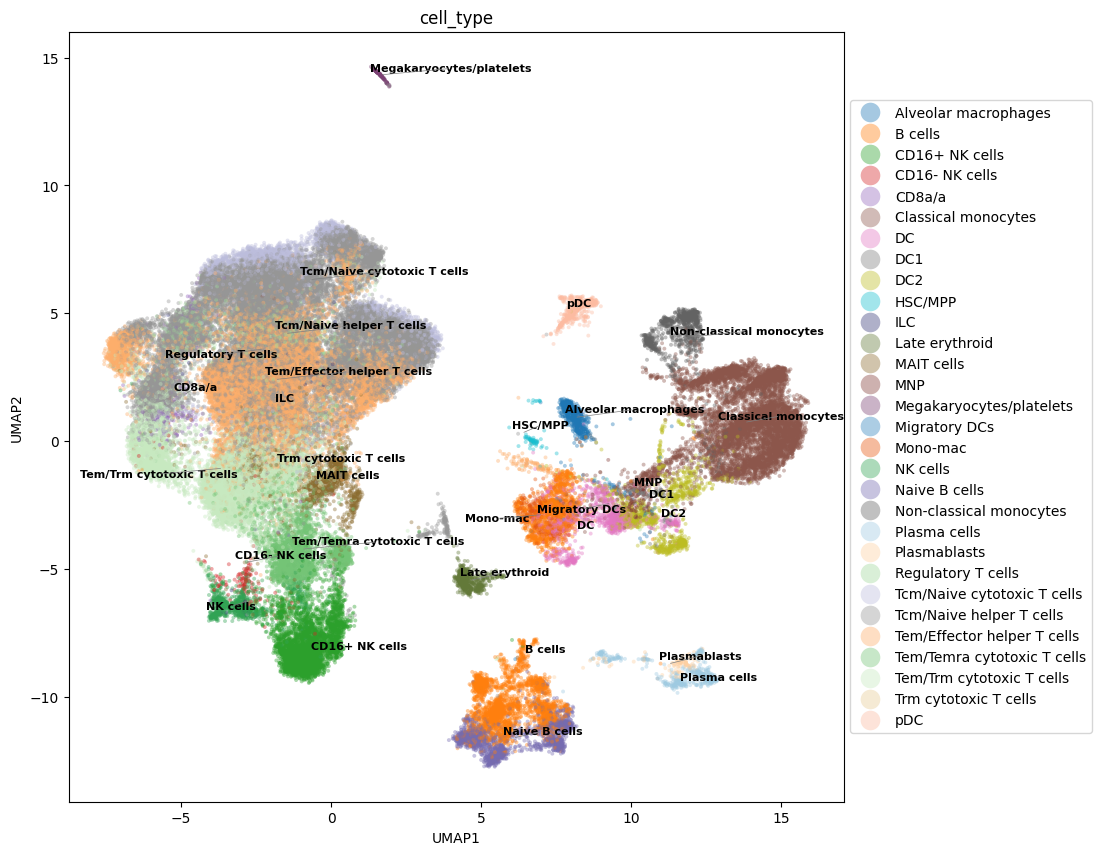

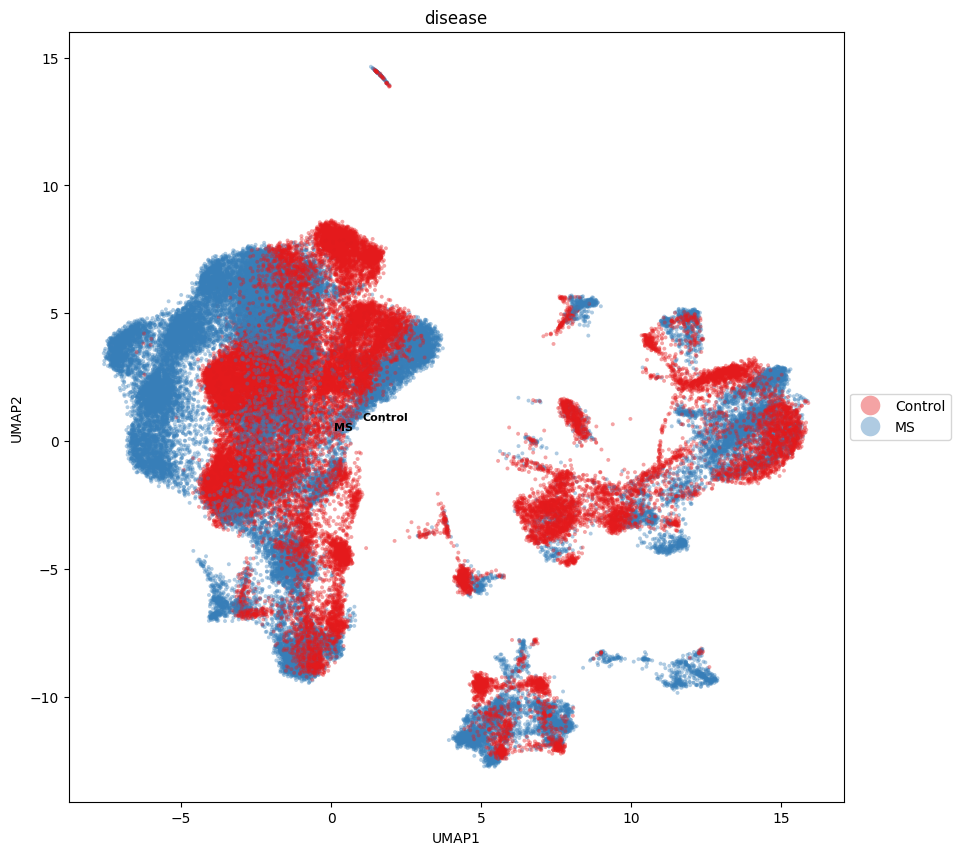

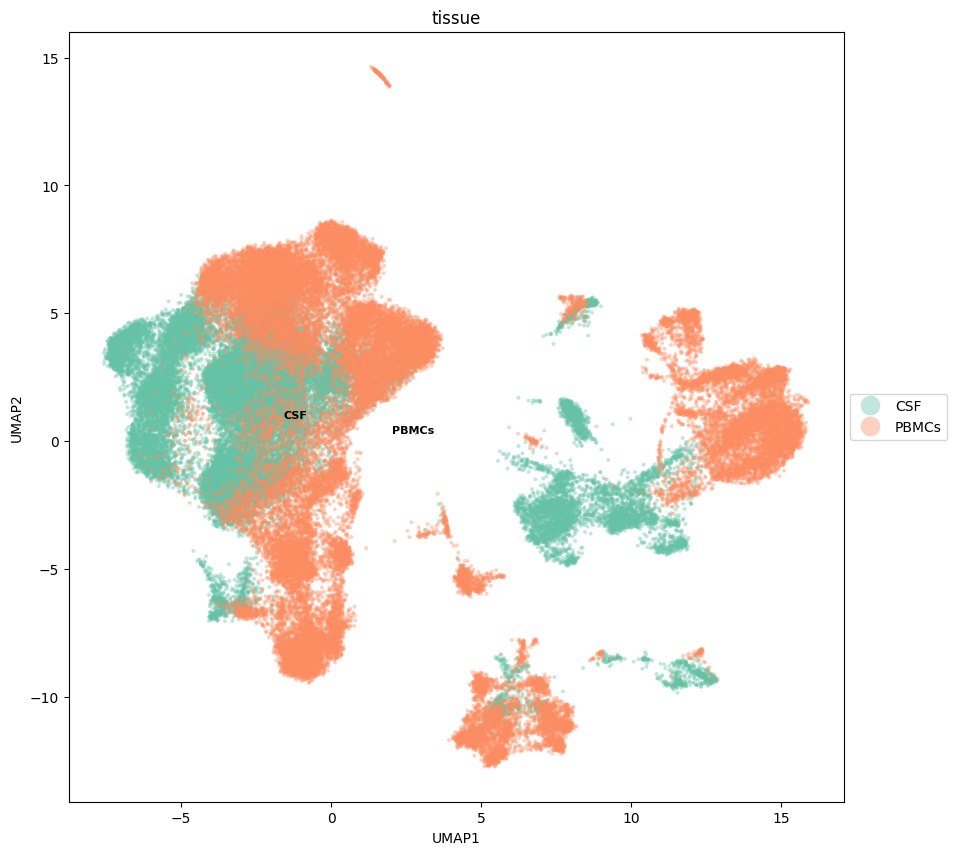

In [11]:
custom_palette_30 = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",  # 0–4
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # 5–9
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173",  # 10–14
    "#3182bd", "#e6550d", "#31a354", "#756bb1", "#636363",  # 15–19
    "#9ecae1", "#fdd0a2", "#a1d99b", "#bcbddc", "#969696",  # 20–24
    "#fdae6b", "#74c476", "#c7e9c0", "#e7cb94", "#fcbba1"   # 25–29
]

plot_umap(
    adata,
    color_by="cell_type",
    s=8,
    alpha=0.4,
    palette=custom_palette_30,
    figsize=(10, 10),
    label_clusters=True,
    labelsize=8,
    arrowprops=dict(arrowstyle="-", lw=0.5, color="gray"),
)

plot_umap(
    adata,
    color_by="disease",
    s=8,
    alpha=0.4,
    palette="Set1",
    figsize=(10, 10),
    label_clusters=True,
    labelsize=8,
    arrowprops=dict(arrowstyle="-", lw=0.5, color="gray"),
)

plot_umap(
    adata,
    color_by="tissue",
    s=8,
    alpha=0.4,
    palette="Set2",
    figsize=(10, 10),
    label_clusters=True,
    labelsize=8,
    arrowprops=dict(arrowstyle="-", lw=0.5, color="gray"),
)

In [43]:
mt_pex_genes = ['CROT', 'PLAAT3', 'ACOT8', 'PRDX5', 'ACSL4', 'PNPLA8', 'ECI2', 'ECH1', 'ACSL3', 'DUT', 'GSTK1', 'PPRC1', 'PPARGC1B', 'LDHB', 'MUL1', 'PDK3', 'SOD1', 'ATAD1', 'MDH1', 'IDH2', 'LPIN1', 'AMACR', 'DNM1L', 'CRAT', 'STING1', 'IDH1', 'ACSL1', 'GNPAT', 'CAT', 'GPS2', 'HSDL2']

In [41]:
# ──────────────────────────────────────────────────────────────
#  Fancy violin / boxen plot helper
# ──────────────────────────────────────────────────────────────
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Union

from seaborn.utils import axlabel

def plot_grouped_score(
    adata:      sc.AnnData,
    y:          str,                  # key in .obs, e.g. "mt_pex_score"
    group_by:   str = "cell_type",
    hue:        Optional[str] = "disease",
    *,
    figsize:    tuple = (12, 5),
    order:      Optional[list] = None,  # specific order of categories
    palette:    Union[str, list, dict, None] = "Set3",
    style:      str = "violin",       # "violin", "box", "boxen", "strip"
    inner:      str = "quartile",     # violin inner: “quartile” | “box” | “point”
    scale:      str = "width",        # violin scale: “width” | “area” | “count”
    dodge:      bool = True,
    width:      float = .8,
    showfliers: bool = False,         # for box
    s:          int   = 2,            # strip/ swarm size
    alpha:      float = .7,
    ax:         Optional[plt.Axes] = None,
    save:       Optional[Union[str, Path]] = None,
    dpi:        int = 300,
) -> plt.Axes:
    """
    Versatile plotting of a numeric score along one+ categorical variables.

    Parameters
    ----------
    style : {"violin","box","boxen","strip","swarm"}  Type of plot.
    dodge : bool  Separate hue categories side‑by‑side
    width : float For violin/box
    palette : can be seaborn palette name, list, or dict
    save : path-like -> write figure to file
    """
    df = adata.obs[[y, group_by] + ([hue] if hue else [])].copy()
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[y])

    ax = ax or plt.figure(figsize=figsize).gca()

    plot_kwargs = dict(
        data=df,
        x=group_by,
        y=y,
        order=order,
        hue=hue,
        palette=palette,
        dodge=dodge,
        ax=ax,
    )

    if style == "violin":
        sns.violinplot(**plot_kwargs, scale=scale, inner=inner, cut=0, width=width)
    elif style == "box":
        sns.boxplot(**plot_kwargs, width=width, showfliers=showfliers)
    elif style == "boxen":
        sns.boxenplot(**plot_kwargs, width=width, showfliers=showfliers)
    elif style in {"strip", "swarm"}:
        func = sns.stripplot if style == "strip" else sns.swarmplot
        func(**plot_kwargs, size=s, alpha=alpha, linewidth=.5, edgecolor="gray")
    else:
        raise ValueError(f"Unknown style '{style}'")

    ax.set_xlabel(group_by)
    ax.set_ylabel(y)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # tight layout & save
    plt.tight_layout()
    if save:
        Path(save).parent.mkdir(exist_ok=True, parents=True)
        ax.get_figure().savefig(save, dpi=dpi)
        print(f"⤴️  figure saved to {save!s}")

    return axlabel

In [42]:
# violin, width‑scaled, quartile lines, 75 × 5 cm figure
plot_grouped_score(
    adata,
    y="mt_pex_score",
    group_by="cell_type",
    hue="disease",
    style="violin",
    scale="width",
    inner="quartile",
    figsize=(15, 5),
    palette="colorblind",
)

KeyError: "['mt_pex_score', 'cell_type'] not in index"

/var/folders/5s/r80y6sqj1_g3k78hjd5zlq1r0000gn/T/ipykernel_66916/3079796112.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adata.obs


['Plasmablasts',
 'CD8a/a',
 'ILC',
 'HSC/MPP',
 'Migratory DCs',
 'Megakaryocytes/platelets',
 'DC1',
 'MNP',
 'CD16- NK cells',
 'Plasma cells',
 'Mono-mac',
 'Trm cytotoxic T cells',
 'Alveolar macrophages',
 'pDC',
 'Late erythroid',
 'DC',
 'NK cells',
 'Non-classical monocytes',
 'DC2',
 'Regulatory T cells',
 'MAIT cells',
 'Naive B cells',
 'Tcm/Naive cytotoxic T cells',
 'Tem/Temra cytotoxic T cells',
 'CD16+ NK cells',
 'B cells',
 'Classical monocytes',
 'Tem/Trm cytotoxic T cells',
 'Tem/Effector helper T cells',
 'Tcm/Naive helper T cells']

<function seaborn.utils.axlabel(xlabel, ylabel, **kwargs)>

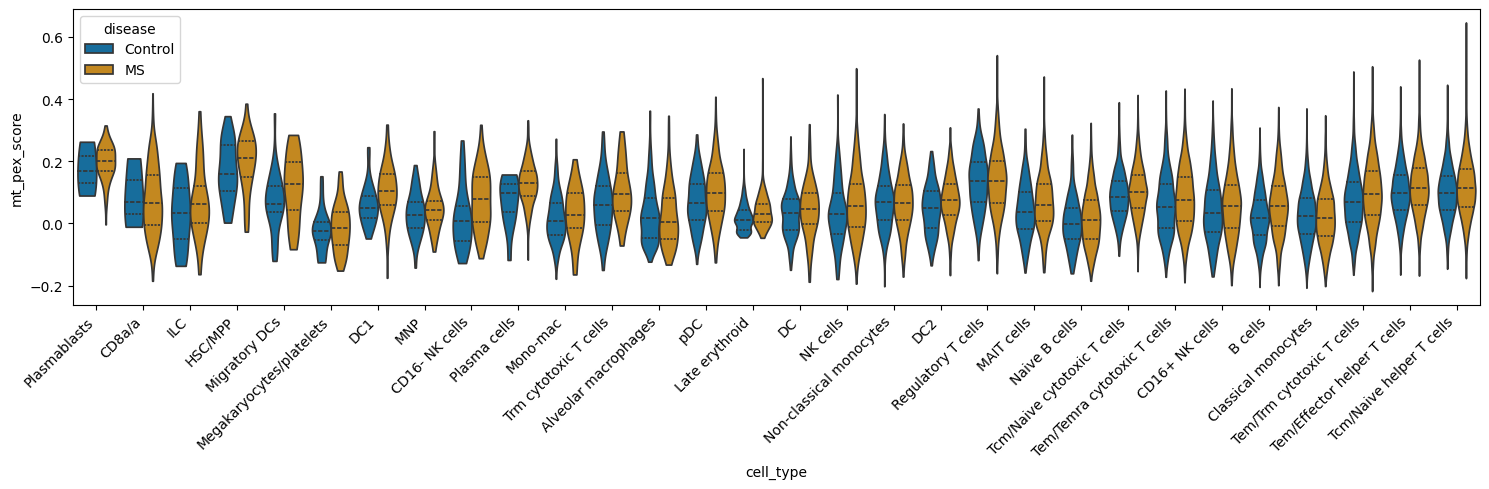

In [30]:
from scipy.stats import mannwhitneyu
order = (
    adata.obs
    .groupby("cell_type")
    .apply(lambda g: mannwhitneyu(g.loc[g.disease == "MS", "mt_pex_score"],
                                  g.loc[g.disease == "Control", "mt_pex_score"])[0])
    .sort_values()
    .index.tolist()
)
order
# order = (
#     adata.obs
#     .groupby("cell_type")
#     .apply(lambda g: g.loc[g.disease == "MS", "mt_pex_score"].mean()
#                     - g.loc[g.disease == "Control", "mt_pex_score"].mean())
#     .sort_values()
#     .index.tolist()
# )

plot_grouped_score(
    adata,
    y="mt_pex_score",
    group_by="cell_type",
    hue="disease",
    style="violin",
    scale="width",
    inner="quartile",
    figsize=(15, 5),
    palette="colorblind",
    order=order,
)

In [26]:
from scipy.stats import mannwhitneyu
import pandas as pd

def per_celltype_mannwhitneyu(
    adata: sc.AnnData,
    group_col: str = "cell_type",
    condition_col: str = "disease",
    score_col: str = "mt_pex_score",
    group1: str = "MS",
    group2: str = "Control",
) -> pd.DataFrame:
    """
    Run Mann–Whitney U test between group1 and group2 within each category of `group_col`.
    Returns a DataFrame with p-values and effect directions.
    """
    results = []
    for celltype, df in adata.obs.groupby(group_col):
        x = df.loc[df[condition_col] == group1, score_col]
        y = df.loc[df[condition_col] == group2, score_col]

        if len(x) > 0 and len(y) > 0:
            stat, p = mannwhitneyu(x, y, alternative="two-sided")
            delta = x.mean() - y.mean()  # effect size
            results.append({
                group_col: celltype,
                "p_value": p,
                "effect_size": delta,
                "n_group1": len(x),
                "n_group2": len(y),
            })

    return pd.DataFrame(results).sort_values("p_value")

results_df = per_celltype_mannwhitneyu(adata, group_col='cell_type', condition_col='disease', group1='MS', group2='Control')
results_df.sort_values(by='p_value', ascending=True).head()


# results_df = per_celltype_mannwhitneyu(adata, group_col='cell_type', condition_col='tissue', group1='CSF', group2='PBMCs')
# results_df.sort_values(by='p_value', ascending=True).head()


,cell_type,p_value,effect_size,n_group1,n_group2
24,Tcm/Naive helper T cells,8.505486e-43,0.017088,14277,8281
27,Tem/Trm cytotoxic T cells,1.303397e-35,0.028256,4571,3441
1,B cells,5.574126e-33,0.035841,1747,1970
25,Tem/Effector helper T cells,3.281864e-29,0.017358,6414,6417
26,Tem/Temra cytotoxic T cells,2.697780e-09,0.021263,1836,1297


<Axes: xlabel='effect_size', ylabel='cell_type'>

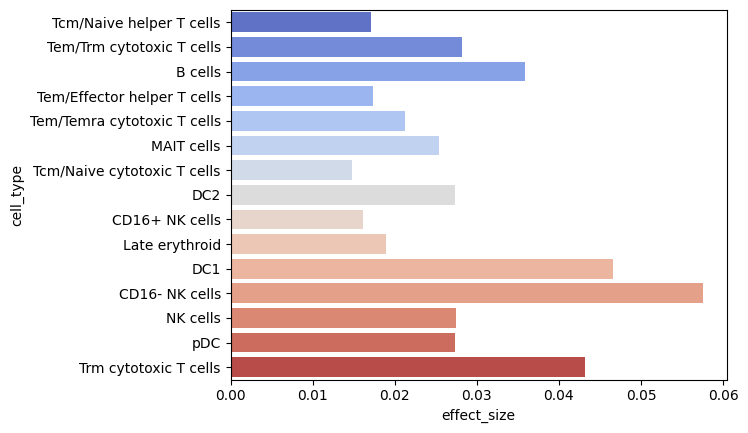

In [28]:
sns.barplot(data=results_df.query("p_value < 0.01"),
            x="effect_size", y="cell_type", orient="h", palette="coolwarm")


In [18]:
def add_interpretable_effect(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a column with an interpretable % probability from Cliff's delta.
    """
    df = df.copy()
    df['pct_larger_MS'] = ((df['effect_size'] + 1) / 2) * 100
    return df

def plot_score_by_cell_type(
    adata,
    score_key="mt_pex_score",
    groupby="cell_type",
    hue="disease",
    figsize=(16, 6),
    order=None,
    rotate_xticks=45,
    save=None,
):
    """
    Violin plot of gene score per group, split by disease.
    """
    df = adata.obs[[score_key, groupby, hue]].copy()

    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(
        data=df,
        x=groupby,
        y=score_key,
        hue=hue,
        split=True,
        inner="quartile",
        linewidth=1,
        ax=ax
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_xticks, ha="right")
    ax.set_title(f"{score_key} per {groupby}")
    if save:
        fig.savefig(save, bbox_inches="tight", dpi=300)

    return fig, ax


(<Figure size 1600x600 with 1 Axes>,
 <Axes: title={'center': 'mt_pex_score per cell_type'}, xlabel='cell_type', ylabel='mt_pex_score'>)

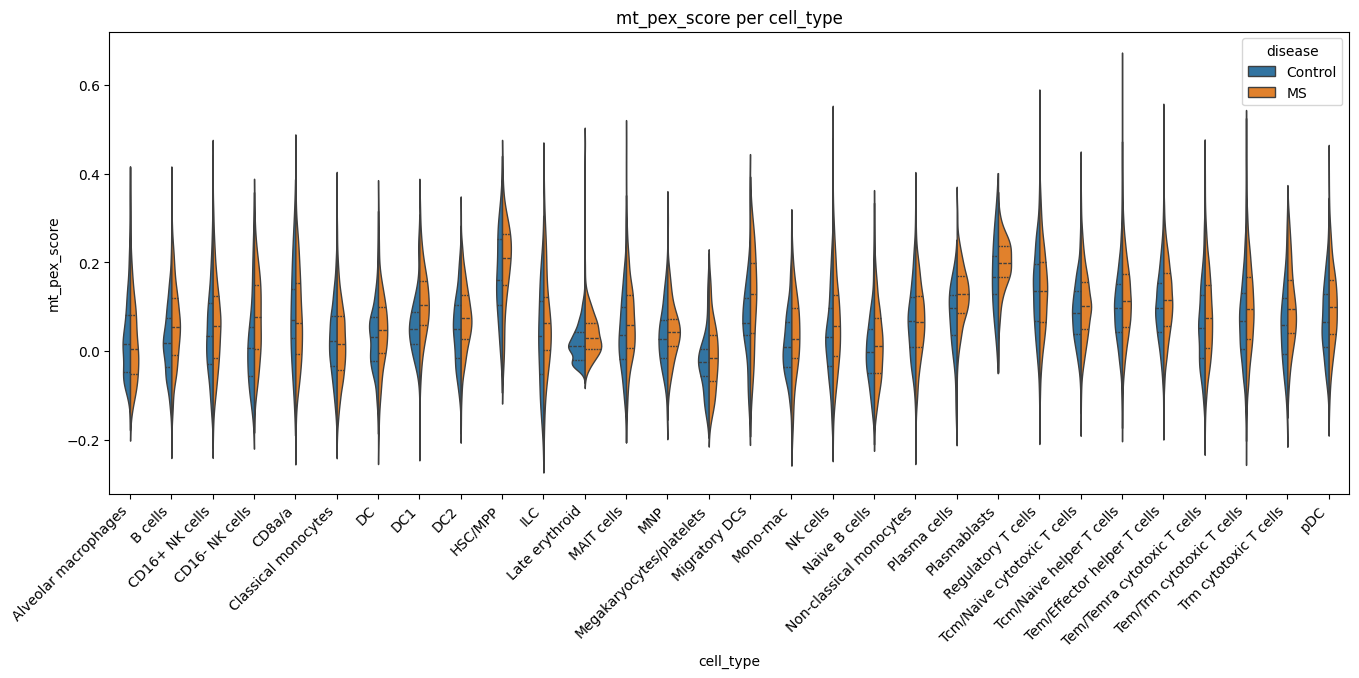

In [29]:
plot_score_by_cell_type(adata=adata, score_key='mt_pex_score', groupby='cell_type', hue='disease')

In [ ]:
def refine_effect_table(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["pct_MS_higher"] = ((df["effect_size"] + 1) / 2) * 100
    return df.sort_values("p_value")
plot_score_by_cell_type(
    adata[adata.obs["cell_type"].isin([
        "Plasmablasts", "Tcm/Naive helper T cells", "Migratory DCs"
    ])],
    score_key="mt_pex_score",
    groupby="cell_type",
    hue="disease",
    figsize=(6, 4),
)
plot_umap(
    adata[adata.obs["cell_type"] == "Plasmablasts"],
    color_by="mt_pex_score",
    cmap="Reds",
    s=5,
    alpha=0.6
)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

def plot_multipanel_summary(
    adata,
    score_key="mt_pex_score",
    groupby="cell_type",
    condition_key="disease",
    umap_key="X_umap",
    label_clusters=True,
    label_size=9,
    figsize=(16, 8),
    palette=None,
    top_n=20,
):
    # 1. Compute per-cell-type Mann-Whitney U and Cliff’s delta
    from scipy.stats import mannwhitneyu
    import pandas as pd
    import numpy as np

    rows = []
    for ct, df in adata.obs[[groupby, condition_key, score_key]].groupby(groupby):
        g1 = df[df[condition_key] == "Control"][score_key]
        g2 = df[df[condition_key] == "MS"][score_key]
        if len(g1) < 10 or len(g2) < 10:
            continue
        u = mannwhitneyu(g1, g2, alternative="two-sided")
        n1, n2 = len(g1), len(g2)
        more = sum(x > y for x in g2 for y in g1)
        less = sum(x < y for x in g2 for y in g1)
        d = (more - less) / (n1 * n2)
        rows.append((ct, u.pvalue, d, n1, n2))

    effect_df = pd.DataFrame(rows, columns=["cell_type", "p_value", "effect_size", "n_group1", "n_group2"])
    top_celltypes = (
        effect_df.loc[effect_df["p_value"] < 0.05]
        .sort_values("effect_size", key=np.abs, ascending=False)
        .head(top_n)["cell_type"]
        .tolist()
    )

    # Setup figure
    fig, axs = plt.subplots(2, 2, figsize=figsize, gridspec_kw=dict(height_ratios=[1, 1.2]))
    (ax_bar, ax_violin), (ax_umap_expr, ax_umap_label) = axs

    # Barplot of effect sizes
    plot_df = effect_df.query("cell_type in @top_celltypes").copy()
    plot_df = plot_df.sort_values("effect_size", ascending=True)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.barplot(
        data=plot_df,
        y="cell_type",
        x="effect_size",
        palette=cmap(plot_df["effect_size"] / plot_df["effect_size"].abs().max() / 2 + 0.5),
        ax=ax_bar,
    )
    ax_bar.set_title("Effect size (Cliff's delta)")
    ax_bar.set_xlabel("effect_size")
    ax_bar.set_ylabel(groupby)

    # Violin plot
    from seaborn import violinplot
    violinplot(
        data=adata.obs[adata.obs[groupby].isin(top_celltypes)],
        x=groupby,
        y=score_key,
        hue=condition_key,
        palette=palette or "Set2",
        split=True,
        inner="quart",
        ax=ax_violin,
    )
    ax_violin.set_xticklabels(ax_violin.get_xticklabels(), rotation=45, ha="right")
    ax_violin.set_title(f"{score_key} per {groupby}")

    # UMAP score expression
    coords = adata.obsm[umap_key]
    ax_umap_expr.scatter(
        coords[:, 0],
        coords[:, 1],
        c=adata.obs[score_key],
        cmap="Blues",
        alpha=0.3,
        s=2,
    )
    ax_umap_expr.set_title(f"UMAP colored by {score_key}")
    ax_umap_expr.set_xlabel("UMAP1")
    ax_umap_expr.set_ylabel("UMAP2")

    # UMAP cluster labels
    ax_umap_label.scatter(
        coords[:, 0],
        coords[:, 1],
        c="lightgray",
        s=1,
        alpha=0.1,
    )
    if label_clusters:
        texts = []
        for ct in top_celltypes:
            mask = adata.obs[groupby] == ct
            if mask.sum() == 0:
                continue
            x, y = coords[mask].mean(axis=0)
            texts.append(ax_umap_label.text(x, y, ct, fontsize=label_size, weight="bold"))
        adjust_text(texts, ax=ax_umap_label, expand_text=(1.1, 1.2))

    ax_umap_label.set_title(f"UMAP with {groupby} labels")
    ax_umap_label.set_xlabel("UMAP1")
    ax_umap_label.set_ylabel("UMAP2")

    fig.tight_layout()
    return fig


from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

def compute_effects_by_cell_type(adata, score_key="mt_pex_score", groupby="cell_type", condition_key="disease"):
    results = []
    for ct in adata.obs[groupby].unique():
        sub = adata[adata.obs[groupby] == ct].obs
        group1 = sub[sub[condition_key] == "Control"][score_key]
        group2 = sub[sub[condition_key] == "MS"][score_key]

        if len(group1) >= 3 and len(group2) >= 3:
            stat, p = mannwhitneyu(group1, group2, alternative="two-sided")
            # Cliff's delta as a standardized effect size
            n1, n2 = len(group1), len(group2)
            u = stat
            d = (2 * u / (n1 * n2)) - 1
            results.append({
                "cell_type": ct,
                "p_value": p,
                "effect_size": d,
                "n_group1": n1,
                "n_group2": n2
            })

    return pd.DataFrame(results)

# generate the DataFrame
effect_df = compute_effects_by_cell_type(adata)


In [ ]:
plot_multipanel_summary(
    adata,
    # celltypes=effect_df.sort_values("p_value").head(15)["cell_type"],  # e.g., effect_df.sort_values("p_value").head(15)["cell_type"]
    score_key="mt_pex_score",
    # effect_df=effect_df,
)


In [ ]:
var_names = [x for x in mt_pex_genes if x in adata.var_names]
print(f'Genes that are present: {len(var_names)}')
sc.pl.dotplot(adata, var_names=var_names, groupby="disease")


In [ ]:
import celltypist
model = celltypist.models.Model.load("../data/Immune_All_Low.pkl")

# prepare_for_celltypist(prepared_adata)
# pred = celltypist.annotate(prepared_adata, model=model, majority_voting=True)
# prepared_adata.obs["cell_type"] = prepared_adata.predicted_labels["majority_voting"]

import matplotlib.pyplot as plt
from matplotlib import rcParams

# set default figure size before plotting
rcParams['figure.figsize'] = (40, 20)

# Generate the plot (but don't auto-show yet)
sc.pl.violin(
    prepared_adata[prepared_adata.obs['disease'] == 'MS', :],
    keys="mt_pex_score",
    groupby="cell_type",
    scale="width",
    stripplot=True,
    show=False,
    size=15,
)

# Rotate x-axis labels
_ = plt.xticks(rotation=45, ha='right')
_ = plt.tick_params(axis='x', labelsize=15)
_ = plt.tight_layout()
_ = plt.show()


# Generate the plot (but don't auto-show yet)
sc.pl.violin(
    prepared_adata[prepared_adata.obs['disease'] == 'Control', :],
    keys="mt_pex_score",
    groupby="cell_type",
    scale="width",
    stripplot=True,
    show=False,
    size=15,
)

# Rotate x-axis labels
_ = plt.xticks(rotation=45, ha='right')
_ = plt.tick_params(axis='x', labelsize=15)
_ = plt.tight_layout()
_ = plt.show()



In [ ]:
prepared_adata.obs

In [ ]:
fig = plt.gcf()
fig.set_size_inches(40, 20)  # now set the size
plt.show()

In [3]:
mt_hpa = (
    pd.read_csv('../data/hpa/Mitochondria.tsv', delimiter='\t')
        .dropna(subset=['Subcellular location', 'Molecular function'])
)

mt_loc_mask = mt_hpa['Subcellular location'].str.contains('Mito')
blood_cell_mask = mt_hpa['RNA blood cell distribution'].isin(['Detected in all', 'Detected in many', 'Detected in some'])


mt_hpa_filt = mt_hpa.loc[blood_cell_mask, :]

mt_genes_hpa = mt_hpa_filt['Gene'].tolist()
pex_genes_hpa = pd.read_csv('../data/hpa/Peroxisome.tsv', delimiter='\t')['Gene'].tolist()

print('Number of genes in Mitochondria: ', len(mt_genes_hpa))
print('Number of genes in Peroxisome: ', len(pex_genes_hpa))
print('Number of genes in both: ', len(set(mt_genes_hpa).intersection(pex_genes_hpa)))

shared_genes = set(mt_genes_hpa).intersection(pex_genes_hpa)
print('Shared genes: ', shared_genes)



Number of genes in Mitochondria:  799
Number of genes in Peroxisome:  189
Number of genes in both:  31
Shared genes:  {'CROT', 'STING1', 'SOD1', 'GSTK1', 'GNPAT', 'CAT', 'ACSL4', 'DUT', 'ACSL1', 'ECH1', 'ACSL3', 'PDK3', 'LDHB', 'PPRC1', 'GPS2', 'AMACR', 'CRAT', 'PRDX5', 'PNPLA8', 'MDH1', 'ACOT8', 'PPARGC1B', 'ECI2', 'MUL1', 'LPIN1', 'HSDL2', 'IDH2', 'ATAD1', 'DNM1L', 'IDH1', 'PLAAT3'}


In [10]:
pex_table = pd.read_csv('../data/hpa/Peroxisome.tsv', delimiter='\t')
mt_table = pd.read_csv('../data/hpa/Mitochondria.tsv', delimiter='\t')

pex_table.merge(mt_table, on='Gene', suffixes=['_pex', '_mt']).to_clipboard()

In [52]:
import anndata as ad

adata = ad.read_h5ad('../data/MS_CSF.h5ad')
adata
adata.obs
# adata
# adata.obs.head().to_clipboard()
# adata.obs.dtypes
# adata.obs['MS'].value_counts()
# adata.obs['CSF'].value_counts()

adata_ms = adata[adata.obs['MS'].astype(str) == 'True'].copy()
adata_ctrl = adata[adata.obs['MS'].astype(str) == 'False'].copy()

adata_csf = adata[adata.obs['CSF'].astype(str) == 'True'].copy()
adata_blood = adata[adata.obs['CSF'].astype(str) == 'False'].copy()

adata_ms.shape
adata_ctrl.shape
adata_csf.shape
adata_blood.shape

AnnData object with n_obs × n_vars = 65326 × 10266
    obs: 'labels', 'MS', 'CSF', 'valid_clusters', 'CD4_labels'
    obsm: 'X_umap'

,labels,MS,CSF,valid_clusters,CD4_labels
0,Gran,False,True,True,-1
1,CD4,False,True,True,6
2,CD4,False,True,True,1
3,ncMono,False,True,True,-1
4,CD4,False,True,True,2
...,...,...,...,...,...
65321,RBC,False,False,False,-1
65322,CD8a,False,False,True,-1
65323,RBC,False,False,False,-1
65324,CD8n,False,False,True,-1


(35483, 10266)

(29843, 10266)

(22357, 10266)

(42969, 10266)

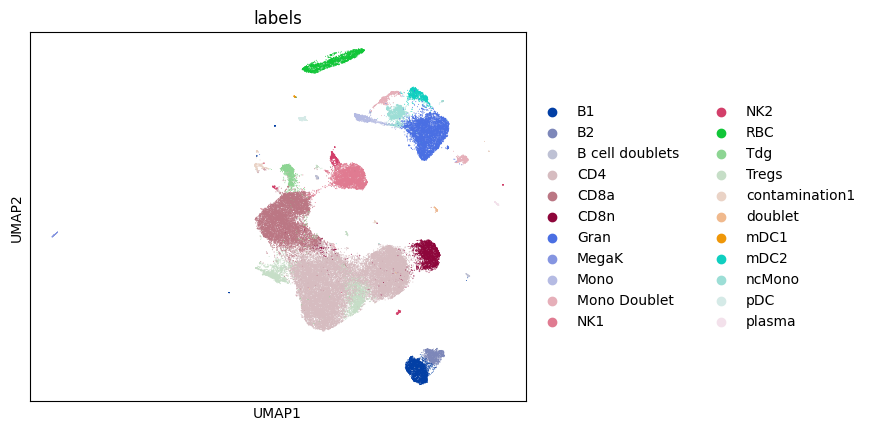

In [57]:
import seaborn as sns
import scanpy as sc

sc.pl.umap(adata, color='labels')